# Machine Learning for Dairy Cattle Genomic Selection

## Part 1: Data Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import datetime as dt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from matplotlib.pyplot import figure
import math
from scipy.stats import loguniform
import itertools
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor

In [2]:
#Loading the data
ebi22 = pd.read_csv(r"C:\Users\emili\OneDrive\Escritorio\NUIG\Proyect\datos.csv")
ebi17 = pd.read_csv(r'C:\ProgramData\MySQL\MySQL Server 8.0\Uploads\EBI_2017.csv', encoding= 'unicode_escape')

In [3]:
#selecting only the target features in the 2022 dataset
ebi22 = ebi22.iloc[:,[0, 8, 9, 11, 13, 15, 17, 19, 21, 23, 27, 28, 29, 34, 35]]
#dropping useless features in the 2017 dataset
ebi17 = ebi17.drop(['  HBNO', '  Name of Bull', '  Name of Sire', '  Name of Dam'], axis = 1) 
#dropping duplicated features in the 2017 dataset
ebi17 = ebi17.drop(['Production Trait Evaluation Rel %', 'Fertility and Survival Evaluation REL %'], axis = 1)

### Cleaning the 2017 dataset

In [4]:
#dropping rows that showed data loading problems, which are DP bulls anyway
ebi17 = ebi17.drop(list(ebi17[ebi17.iloc[:,1].isna()].index))

In [5]:
#dropping columns with only one value (no discriminatory power)
h = []
for i in ebi17.columns:
    h += [len(ebi17[i].value_counts())]
ebi17 = ebi17.drop(ebi17.columns[pd.DataFrame(h)[pd.DataFrame(h)[0] == 1][0].index], axis = 1)

In [6]:
#Changing the excel date to year
ebi17[' Birth Date'] = (pd.TimedeltaIndex(ebi17[' Birth Date'], unit='d') + dt.datetime(1900,1,1)).year

### Missing values in categorical features
There are 203 missing values in the "Type of Proof" feature. This is a crucial feature, therefore I'll try to fill them based on the existance of theyr progeny's lactation data.

I'm going to use a Decision Tree Classifier to fill the missing proof values

In [8]:
#Preparing the data to fit it to the model
fill = ebi17[ebi17[' Type of  Proof'] != '0']
fill[' Type of  Proof'][fill[' Type of  Proof']=='GS'] = 1
fill[' Type of  Proof'][fill[' Type of  Proof']!=1] = 0

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1152308947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fill[' Type of  Proof'][fill[' Type of  Proof']=='GS'] = 1
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1152308947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fill[' Type of  Proof'][fill[' Type of  Proof']=='GS'] = 1
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1152308947.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [10]:
X, y = fill.iloc[:,[1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30]], fill[' Type of  Proof'].astype('int')

In [11]:
#splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#training and testing the model
clf = DecisionTreeClassifier(random_state=2)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Recall Score =', recall_score(y_test, y_pred))

0.9552238805970149

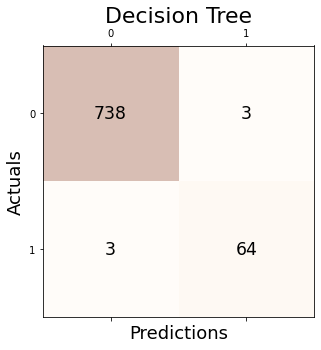

In [13]:
#Displaying the model performance with a confusion matrix
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Decision Tree', fontsize=22)
plt.show()

The decision tree looks reliable enough to fill the missing values

In [14]:
X_fill = ebi17[ebi17[' Type of  Proof'] == '0'].iloc[:,[1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 24, 25, 26, 27, 28, 29, 30]]

In [15]:
ebi17[' Type of  Proof'][list(X_fill[list(clf.predict(X_fill)==1)].index)] = 'GS'

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\779884531.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebi17[' Type of  Proof'][list(X_fill[list(clf.predict(X_fill)==1)].index)] = 'GS'


In [16]:
ebi17[' Type of  Proof'].value_counts()

DP-IRL        2515
DP-INT        1214
GS             413
0               81
CONVERSION      20
Name:  Type of  Proof, dtype: int64

In [17]:
#Dropping all DP and CONVERSION bulls
ebi17 = ebi17[ebi17[' Type of  Proof'] == 'GS']

In [18]:
pd.DataFrame(ebi17.describe(include = 'all').iloc[0].values)[0].value_counts()

413    86
Name: 0, dtype: int64

In [19]:
ebi17 = ebi17.reset_index()
ebi17 = ebi17.drop('index', axis = 1)

### Cleaning the 2022 dataset:

In [21]:
ebi22.describe(include='all')

,Bull,Proof Type,EBI,Milk SI,Fert SI,Calv SI,Beef SI,Maint SI,Mgt SI,Health SI,Milk kg,Fat kg,Protein kg,Calv. Int [days],Survival %
count,5708,5708,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000,5708.000000
unique,5708,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,FR7143,DP-IRL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,3440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,46.731079,29.131219,-0.348809,13.301507,-11.988612,14.216713,0.100210,2.327786,76.546664,5.615804,4.139128,0.263958,0.239366
std,NaN,NaN,128.438439,48.127577,79.912782,29.049803,16.617794,17.172319,5.688403,10.443904,269.219211,9.269298,7.959668,4.471029,2.209793
min,NaN,NaN,-459.000000,-129.000000,-350.000000,-284.000000,-94.000000,-37.000000,-25.000000,-32.000000,-953.060000,-30.450000,-26.080000,-14.710000,-9.780000
25%,NaN,NaN,-49.000000,-6.000000,-53.000000,-2.000000,-16.000000,4.000000,-3.000000,-5.000000,-95.372500,-0.762500,-1.322500,-2.962500,-1.200000
50%,NaN,NaN,55.000000,28.000000,12.000000,17.000000,-9.000000,11.000000,0.000000,2.000000,83.010000,5.555000,4.175000,-0.280000,0.640000
75%,NaN,NaN,149.000000,65.000000,58.000000,34.000000,-4.000000,20.000000,4.000000,9.000000,251.797500,12.272500,9.732500,3.300000,1.910000


In [22]:
cero = ebi22.replace('  ', np.nan)

In [23]:
cero.describe(include = 'all').iloc[0].value_counts()

5708    14
5486     1
Name: count, dtype: int64

There are missing values in the 'Proof Type' column. I'm using a decision tree classifier again to fill this values.

In [24]:
# I have to load the full dataset again to apply the decision tree with all the columns
e22 = pd.read_csv(r"C:\Users\emili\OneDrive\Escritorio\NUIG\Proyect\datos.csv")
#e22 = data22
e22['Proof Type'][e22['Proof Type']=='DP-INT ']=1
e22['Proof Type'][e22['Proof Type']=='DP-IRL ']=1
e22['Proof Type'][e22['Proof Type']=='GS ']=0
e22 = e22[e22['Proof Type'] != '  ']

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2711586303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e22['Proof Type'][e22['Proof Type']=='DP-INT ']=1
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2711586303.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  e22['Proof Type'][e22['Proof Type']=='DP-IRL ']=1
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2711586303.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [25]:
e22['Proof Type'].value_counts()

1    4901
0     585
Name: Proof Type, dtype: int64

In [26]:
X, y = e22[list(e22.columns[e22.dtypes!='object'])], e22['Proof Type'].astype('int')

In [27]:
#Splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#Training and testing the model
clf = DecisionTreeClassifier(random_state=1)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print('Recall Score =', recall_score(y_test, y_pred))

0.9969450101832994

Again, the decision tree looks reliable enough to fill the missing values

In [29]:
f22 = pd.read_csv(r"C:\Users\emili\OneDrive\Escritorio\NUIG\Proyect\datos.csv")
X_fill = f22[f22['Proof Type']=='  '][list(e22.columns[e22.dtypes!='object'])]

In [30]:
ebi22 = pd.read_csv(r"C:\Users\emili\OneDrive\Escritorio\NUIG\Proyect\datos.csv")
fill_ind = X_fill[list(clf.predict(X_fill)==1)].index

In [31]:
for i in fill_ind:
    ebi22['Proof Type'][i] = 'DP-IRL '

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2735386890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ebi22['Proof Type'][i] = 'DP-IRL '


In [32]:
ebi22 = ebi22.iloc[:,[0, 8, 9, 11, 13, 15, 17, 19, 21, 23, 27, 28, 29, 34, 35]]

## Part 2: Merging and Pre-processing

In [33]:
#merging the datasets with the bull code as 'primary key'
df = pd.merge(ebi17, ebi22, how='inner', left_on = ' AI CODE', right_on = 'Bull')

In [34]:
df['Proof Type'].value_counts().keys()

Index(['DP-IRL ', 'DP-INT ', 'GS ', '  '], dtype='object')

Dropping columns that are now useless and bulls that are not DP in 2022

In [35]:
df['Proof Type'] = df['Proof Type'].replace(['DP-IRL ','DP-INT '], 'DP')
df = df[df['Proof Type'] == 'DP']
df = df.drop([' AI CODE', ' Type of  Proof', 'Bull', 'Proof Type', ' Test Stat'], axis = 1)

In [36]:
df.describe(include = 'all').iloc[0].value_counts()

379.0    96
Name: count, dtype: int64

In [37]:
df = df.reset_index().iloc[:,1:]

### The merging was successfully completed, now it's time to prepare the data to be fitted to the models

In [38]:
#transforming categorical variables to numeric
cat = list(df.columns[df.dtypes=='object'])
cat

[' Main Breed', ' Owner Name', '  Cat']

In [39]:
s = 0
for i in cat:
    s += len(df[i].value_counts())
s

32

There are 3 categorical features, adding up to 32 different values. Performing one-hot encoding would largely increase the number of columns in my dataset. For that, I'm going to perform costum binary encoding on the features "Main Breed" and "Cat" (that now will be "Main Breed = Holstein" and "Cat = Pedigree"), one-hot encoding on the feature "Owner Name" but only using the 4 most frequent owners (78% of the total).

In [40]:
df[' Main Breed'][df[' Main Breed']=='HO'] = 1
df[' Main Breed'][df[' Main Breed']!='HO'] = 0
df['  Cat'][df['  Cat']=='PED'] = 1
df['  Cat'][df['  Cat']!='PED'] = 0
df = df.rename(columns={' Main Breed':'Main Breed = HO', '  Cat':'Cat = Ped'})
df['Main Breed = HO'] = df['Main Breed = HO'].astype('int')
df['Cat = Ped'] = df['Cat = Ped'].astype('int')

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1919065709.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Main Breed'][df[' Main Breed']=='HO'] = 1
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1919065709.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Main Breed'][df[' Main Breed']!='HO'] = 0
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\1919065709.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[

In [41]:
for i in range(len(df[' Owner Name'])):
    if df[' Owner Name'][i] not in list(df[' Owner Name'].value_counts().keys()[0:4]):
        df[' Owner Name'][i] = 'other'
ohe = pd.get_dummies(df[' Owner Name'], 'Owner')
df = pd.concat([df, ohe], axis=1)
df = df.drop(' Owner Name', axis = 1)

C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2324923324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Owner Name'][i] = 'other'
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2324923324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Owner Name'][i] = 'other'
C:\Users\emili\AppData\Local\Temp\ipykernel_221912\2324923324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[' Owner Name'][i] = 'other'
C:\U

In [152]:
#Final look at the data
df.describe(include = 'all')

,Birth Date,Main Breed = HO,HO%,EBI Euro,EBI REL,Milk Prod SI Euro,Milk Prod SI REL,Fertility SI Euro,Fertility SI REL,Calving SI Euro,...,dif_maint_si,dif_mgt_si,dif_health_si,dif_milk_kg,dif_fat_kg,dif_protein_kg,dif_calv_int,dif_survival,mean_dif,mean_dif_cat
count,379.000000,379.0,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,...,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000,379.000000
mean,2008.823219,0.0,66.440633,113.772269,59.788918,37.566280,69.440633,41.237546,51.754617,32.643456,...,0.471026,0.428792,0.481793,0.509539,0.513747,0.540271,0.564296,0.552521,0.472537,0.624011
std,7.473260,0.0,39.164198,107.909375,14.343768,50.001538,14.217827,67.761462,17.580968,19.697086,...,0.160645,0.137411,0.159946,0.156004,0.162238,0.143582,0.152397,0.132917,0.057884,0.415225
min,1990.000000,0.0,0.000000,-194.910000,26.000000,-95.430000,15.000000,-178.910000,11.000000,-27.180000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.277422,0.000000
25%,2004.000000,0.0,42.500000,25.880000,53.000000,1.805000,65.000000,-0.760000,46.000000,23.810000,...,0.361792,0.344172,0.381800,0.424386,0.425297,0.457976,0.473664,0.469799,0.434642,0.250000
50%,2013.000000,0.0,81.000000,131.060000,59.000000,48.710000,68.000000,45.820000,52.000000,37.030000,...,0.470755,0.422086,0.492252,0.511016,0.515205,0.538635,0.579396,0.542282,0.471109,0.500000
75%,2014.000000,0.0,100.000000,199.310000,64.000000,74.120000,72.000000,89.875000,57.000000,46.285000,...,0.577358,0.503476,0.576162,0.588046,0.598061,0.620877,0.647173,0.637584,0.509034,1.000000
max,2016.000000,0.0,100.000000,323.500000,91.000000,137.650000,97.000000,236.550000,89.000000,67.580000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.675455,1.000000


## Part 3: Hyperparameter Optimization

A random search and grid search will be performed with every model for every target. That can be automated with two simple algorithms that iterate over every target and save the results. Also, the benchmark performance has to be recorded for each target

In [153]:
#Separating the data from the targets
X , y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13 = df.drop(['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI',
                                                                      'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg',
                                                                      'Protein kg', 'Calv. Int [days]', 'Survival %'],
                                                                     axis = 1), df.iloc[:,-18], df.iloc[:,-17], df.iloc[:,-16], df.iloc[:,-15], df.iloc[:,-14], df.iloc[:,-13], df.iloc[:,-12], df.iloc[:,-11], df.iloc[:,-10], df.iloc[:,-9], df.iloc[:,-8], df.iloc[:,-7], df.iloc[:,-6]
targets = [y1, y2, y3, y4, y5, y6, y7, y8, y9, y10, y11, y12, y13]

In [44]:
#Recording the benchmark performances
b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13 = [df[' EBI Euro'], 
                                                          df[' Milk Prod SI Euro'],
                                                          df[' Fertility SI Euro'], 
                                                          df[' Calving SI Euro'], 
                                                          df[' Carcass SI Euro'], 
                                                          df[' Maintenance SI Euro'], 
                                                          df[' Management SI Euro'], 
                                                          df[' Health SI Euro'], 
                                                          df['Production Trait Evaluation PTA Milk'], 
                                                          df['Production Trait Evaluation PTA Fat'], 
                                                          df['Production Trait Evaluation PTA Prot'], 
                                                          df['Fertility and Survival Evaluation PTA CI'], 
                                                          df['Fertility and Survival Evaluation PTA SUV']]
benchmark = [b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13]
bench_record = []
for i in range(len(benchmark)):
    bench_record += [r2_score(targets[i], benchmark[i])]

### Random Forest

In [46]:
#Automatized randomized search over every target
test = 0.33
record = []
params = []
estimators = []
##########
# Random Grid setting
max_depth = [int(x) for x in np.linspace(10, 110, num = 10)]
max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(10, 400, num = 10)],
               'max_features': [1.0, 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}
##############

for i in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, i, test_size=test, random_state=42)
    clf = RandomForestRegressor(random_state=42)
    clf_rand = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    clf_rand.fit(X_train, y_train)
    record += [clf_rand.score(X_test, y_test)]
    params += [clf_rand.best_params_]
    estimators += [clf_rand.best_estimator_]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


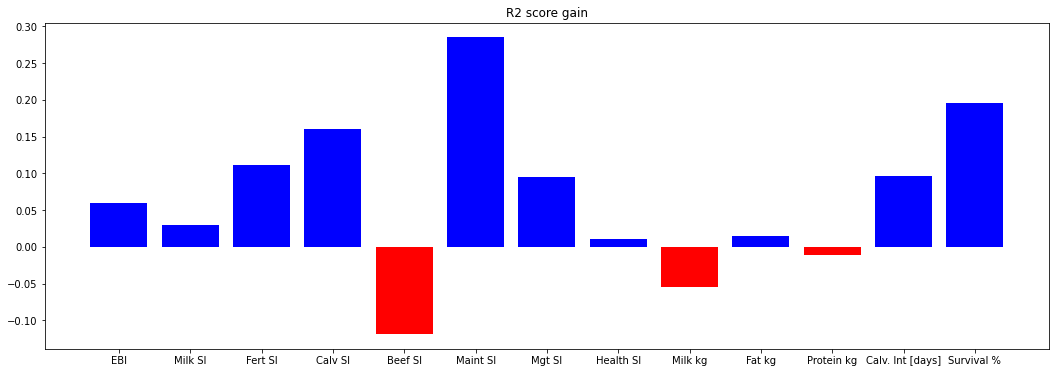

In [47]:
#Plotting the randomized search results in comparison to the benchmark results 
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

Now, for every feature, I'm going to perform a grid search to optimize the models

In [48]:
#supporting function
def max_calc(i):
    if type(params[i]['max_depth']) == int:
        return [abs(int(x)) for x in np.linspace(params[i]['max_depth']-(((110-10)/9)/2), params[i]['max_depth']+(((110-10)/9)/2), num = 4)]
    else:
        return [None]

In [49]:
### Automatized grid search for each target feature
grid_record = []
grid_params = []
grid_estimators = []
for i in range(len(record)):
    param_grid = {
        'bootstrap': [params[i]['bootstrap']],
        'max_depth': max_calc(i), 
        'max_features': [params[i]['max_features']],
        'min_samples_leaf': [int(x) for x in np.linspace(params[i]['min_samples_leaf']-1, params[i]['min_samples_leaf']+1, num = 3) if x > 0],
        'min_samples_split': [int(x) for x in np.linspace(params[i]['min_samples_split']-1, params[i]['min_samples_split']+1, num = 3) if x > 1],
        'n_estimators': [abs(int(x)) for x in np.linspace(params[i]['n_estimators']-(((400-10)/9)/2), params[i]['n_estimators']+(((400-10)/9)/2), num = 4)]
    }
    clf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    X_train, X_test, y_train, y_test = train_test_split(X, targets[i], test_size=test, random_state=42)
    grid_search.fit(X_train, y_train)
    grid_record += [grid_search.score(X_test, y_test)]
    grid_params += [grid_search.best_params_]
    grid_estimators += [grid_search.best_estimator_]

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 96 candidates, totalling 480 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Fitting 5 folds for each of 36 candidates, totalling 180 fits


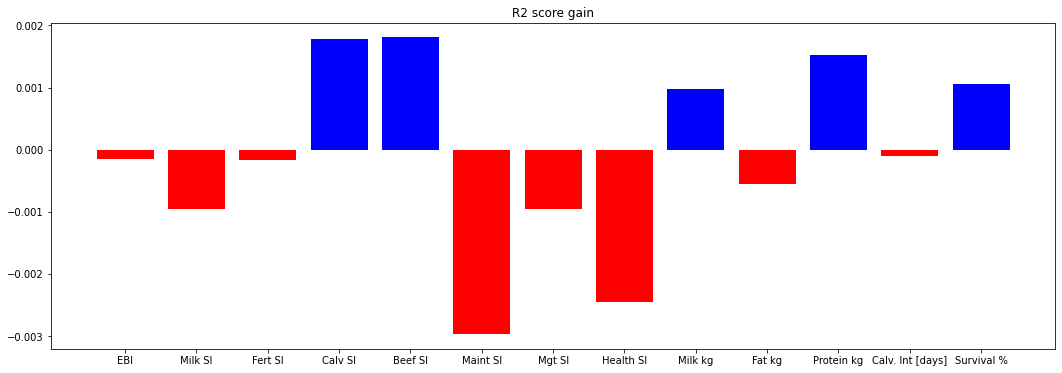

In [50]:
#Plotting the grid search results in comparison to the randomized search results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(grid_record) - np.array(record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [51]:
#Keeping only the grid search parameters that performed better than the randomized search ones
final_record = []
final_params = []
final_estimators = []
for i in range(len(record)):
    if grid_record[i] > record[i]:
        final_record += [grid_record[i]]
        final_params += [grid_params[i]]
        final_estimators += [grid_estimators[i]]
    else:
        final_record += [record[i]]
        final_params += [params[i]]
        final_estimators += [estimators[i]]

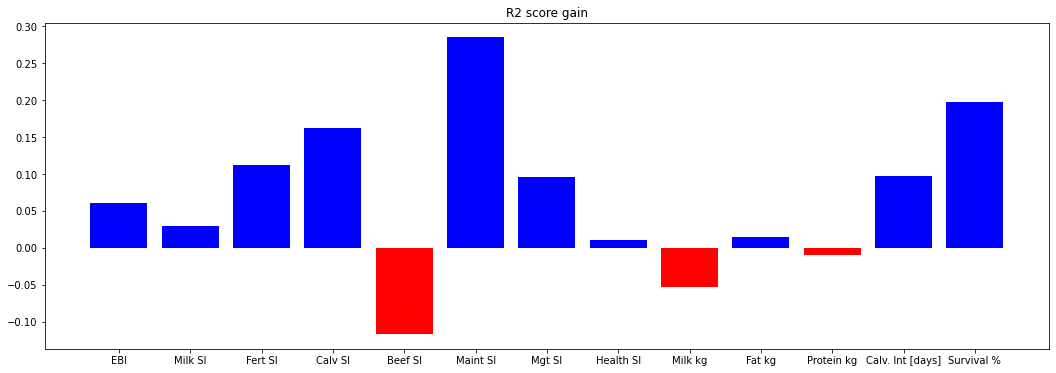

In [52]:
#Plotting the final results in comparison to the benchmark
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(final_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

### Gradient Boosting

In [53]:
test = 0.33
reg_record = []
reg_params = []
reg_estimators = []


random_grid = {
    "n_estimators": [1, 2, 5, 10, 20, 50, 100, 200, 500],
    "max_leaf_nodes": [2, 5, 10, 20, 50, 100],
    "learning_rate": [x for x in np.linspace(0.1, 1.0, num = 10)]
}


for i in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, i, test_size=test, random_state=42)
    reg = GradientBoostingRegressor(random_state=42)
    reg_rand = RandomizedSearchCV(estimator = reg, param_distributions = random_grid, n_iter = 50, cv = 5, verbose=2, random_state=42, n_jobs = -1, error_score='raise')
    reg_rand.fit(X_train, y_train)
    reg_record += [reg_rand.score(X_test, y_test)]
    reg_params += [reg_rand.best_params_]
    reg_estimators += [reg_rand.best_estimator_]

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


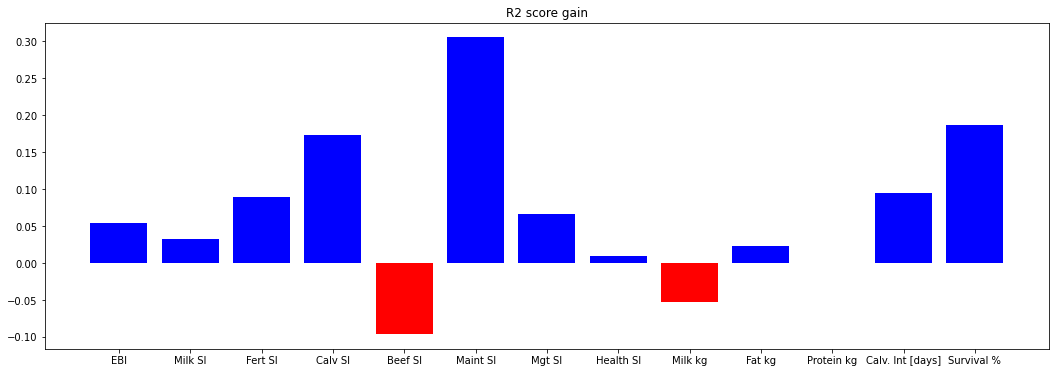

In [54]:
#Plotting the randomized search results in comparison to the benchmark results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(reg_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [55]:
### Automatized grid search for each target feature
reg_grid_record = []
reg_grid_params = []
reg_grid_estimators = []
for i in range(len(reg_record)):
    param_grid = {
        'n_estimators': list(np.unique([int(x) for x in np.linspace(math.floor(reg_params[i]['n_estimators']*(1-0.125)), math.ceil(reg_params[i]['n_estimators']*1.125), num = 7) if int(x) > 0])),
        'max_leaf_nodes': [int(x) for x in np.linspace(reg_params[i]['max_leaf_nodes']-1, reg_params[i]['max_leaf_nodes']+2, num = 4) if int(x) > 1],
        'learning_rate': [x for x in np.linspace(reg_params[i]['learning_rate']*0.1, reg_params[i]['learning_rate']*1.9, num = 5)]
    }
    reg = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator = reg, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    X_train, X_test, y_train, y_test = train_test_split(X, targets[i], test_size=test, random_state=42)
    grid_search.fit(X_train, y_train)
    reg_grid_record += [grid_search.score(X_test, y_test)]
    reg_grid_params += [grid_search.best_params_]
    reg_grid_estimators += [grid_search.best_estimator_]

Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits
Fitting 5 folds for each of 105 candidates, totalling 525 fits


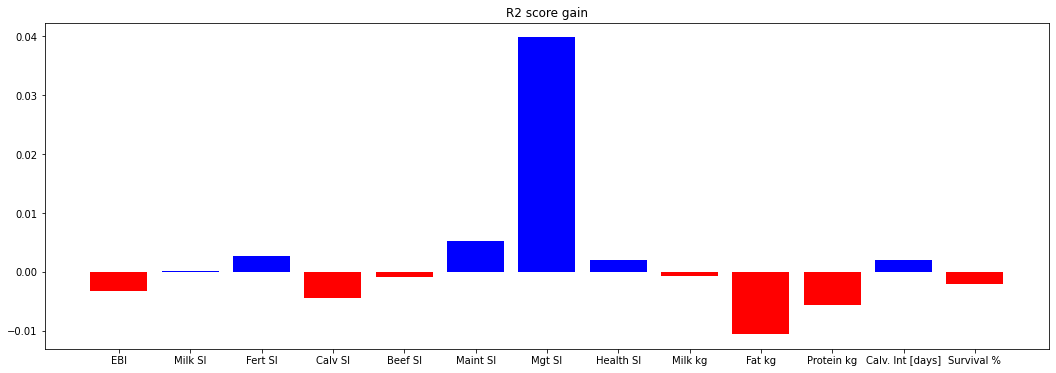

In [56]:
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(reg_grid_record) - np.array(reg_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [57]:
#Keeping only the grid search parameters that performed better than the randomized search ones
final_reg_record = []
final_reg_params = []
final_reg_estimators = []
for i in range(len(reg_record)):
    if reg_grid_record[i] > reg_record[i]:
        final_reg_record += [reg_grid_record[i]]
        final_reg_params += [reg_grid_params[i]]
        final_reg_estimators += [reg_grid_estimators[i]]
    else:
        final_reg_record += [reg_record[i]]
        final_reg_params += [reg_params[i]]
        final_reg_estimators += [reg_estimators[i]]

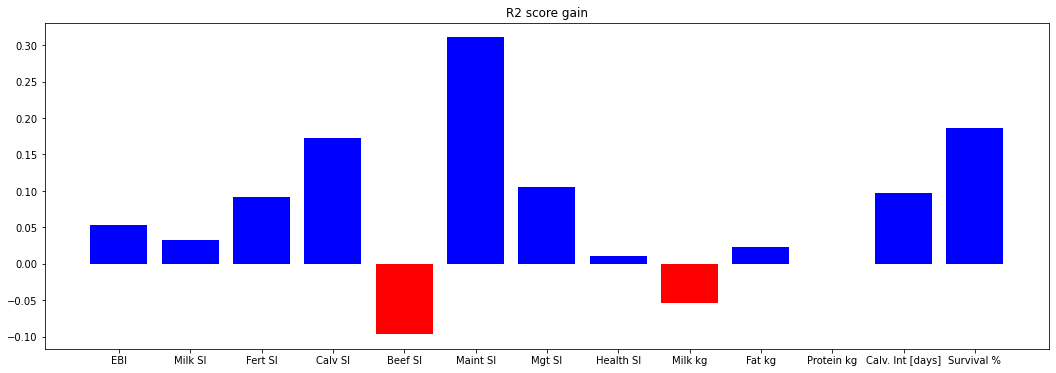

In [58]:
#Plotting the final results in comparison to the benchmark
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(final_reg_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

### Elastic Net

In [59]:
test = 0.33
el_record = []
el_params = []
el_estimators = []

##########
# Random Grid setting
random_grid = {'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
               'l1_ratio': np.linspace(0.0, 0.99, 100)}
##############

for i in targets:
    X_train, X_test, y_train, y_test = train_test_split(X, i, test_size=test, random_state=42)
    el = ElasticNet(random_state=42)
    el_rand = RandomizedSearchCV(estimator = el, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    el_rand.fit(X_train, y_train)
    el_record += [el_rand.score(X_test, y_test)]
    el_params += [el_rand.best_params_]
    el_estimators += [el_rand.best_estimator_]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.175e+04, tolerance: 9.252e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.268e+01, tolerance: 2.128e+00
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.258e+00, tolerance: 2.155e+00
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.898e+02, tolerance: 3.323e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 200 candidates, totalling 1000 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.252e-01, tolerance: 6.453e-02
  model = cd_fast.enet_coordinate_descent(


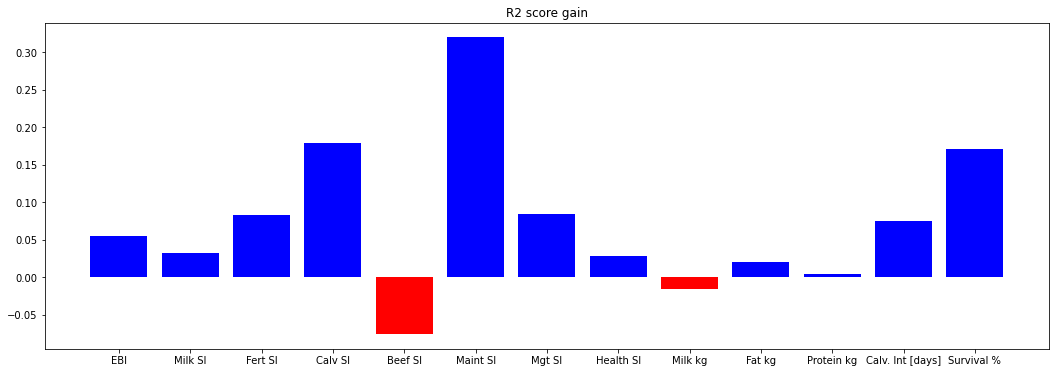

In [60]:
#Plotting the randomized search results in comparison to the benchmark results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(el_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [61]:
### Automatized grid search for each target feature
el_grid_record = []
el_grid_params = []
el_grid_estimators = []
for i in range(len(el_record)):
    param_grid = {
        'l1_ratio': [x for x in np.linspace(el_params[i]['l1_ratio']- 0.005, el_params[i]['l1_ratio']+ 0.005, num = 41) if x >= 0],
        'alpha': [x for x in np.linspace(el_params[i]['alpha']*0.1, el_params[i]['alpha']*1.9, num = 41)]
    }
    el = ElasticNet(random_state=42)
    grid_search = GridSearchCV(estimator = el, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    X_train, X_test, y_train, y_test = train_test_split(X, targets[i], test_size=test, random_state=42)
    grid_search.fit(X_train, y_train)
    el_grid_record += [grid_search.score(X_test, y_test)]
    el_grid_params += [grid_search.best_params_]
    el_grid_estimators += [grid_search.best_estimator_]

Fitting 5 folds for each of 1681 candidates, totalling 8405 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.906e+04, tolerance: 2.520e+02
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 861 candidates, totalling 4305 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.144e+04, tolerance: 9.252e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 1681 candidates, totalling 8405 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.853e+00, tolerance: 2.128e+00
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 1681 candidates, totalling 8405 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.203e+00, tolerance: 2.155e+00
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 1681 candidates, totalling 8405 fits
Fitting 5 folds for each of 861 candidates, totalling 4305 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.052e+02, tolerance: 3.323e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 5 folds for each of 1681 candidates, totalling 8405 fits


C:\Users\emili\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.716e-01, tolerance: 6.453e-02
  model = cd_fast.enet_coordinate_descent(


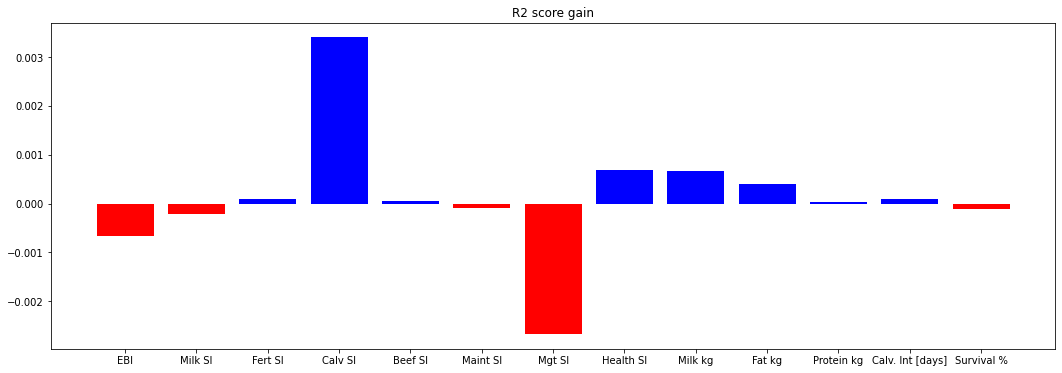

In [62]:
#Plotting the grid search results in comparison to the randomized search results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(el_grid_record) - np.array(el_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [63]:
#Keeping only the grid search parameters that performed better than the randomized search ones
final_el_record = []
final_el_params = []
final_el_estimators = []
for i in range(len(el_record)):
    if el_grid_record[i] > el_record[i]:
        final_el_record += [el_grid_record[i]]
        final_el_params += [el_grid_params[i]]
        final_el_estimators += [el_grid_estimators[i]]
    else:
        final_el_record += [el_record[i]]
        final_el_params += [el_params[i]]
        final_el_estimators += [el_estimators[i]]

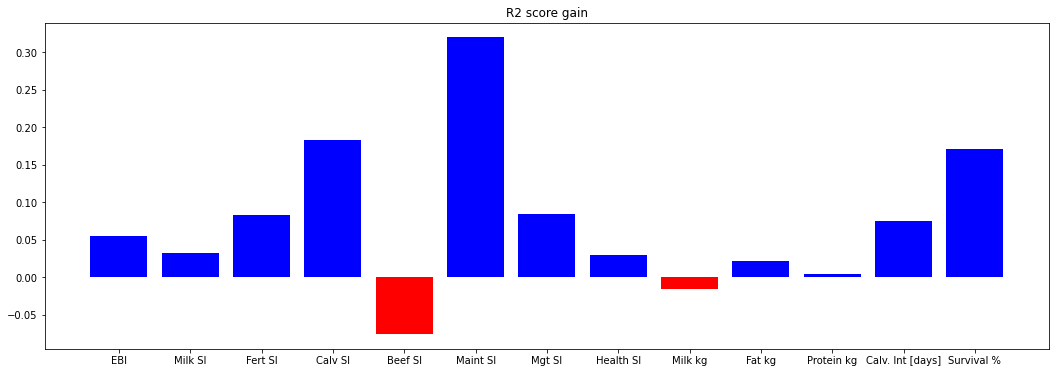

In [64]:
#Plotting the final results in comparison to the benchmark
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(final_el_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

### MLP

In [66]:
test = 0.33
mlp_record = []
mlp_params = []
mlp_estimators = []

scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)

##########
# Random Grid setting
random_grid = {"hidden_layer_sizes": list(itertools.permutations([25,50,100],2)) + list(itertools.permutations([25,50,100],3)),
               "activation": ["identity", "logistic", "tanh", "relu"], 
               "solver": ["lbfgs", "sgd", "adam"],
               'learning_rate' : ['constant', 'adaptive', 'invscaling'],
               "alpha": [0.001,0.0001,0.00001,0.000001]}
##############

for i in targets:
    i = np.array(i).reshape(-1,1)
    scaled_y = scaler.fit_transform(i)
    scaled_y = np.array(scaled_y).reshape(len(scaled_y),)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=test, random_state=42)
    mlp = MLPRegressor(random_state=42)
    mlp_rand = RandomizedSearchCV(estimator = mlp, param_distributions = random_grid, n_iter = 200, cv = 5, verbose=2, random_state=42, n_jobs = -1)
    mlp_rand.fit(X_train, y_train)
    mlp_record += [mlp_rand.score(X_test, y_test)]
    mlp_params += [mlp_rand.best_params_]
    mlp_estimators += [mlp_rand.best_estimator_]

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


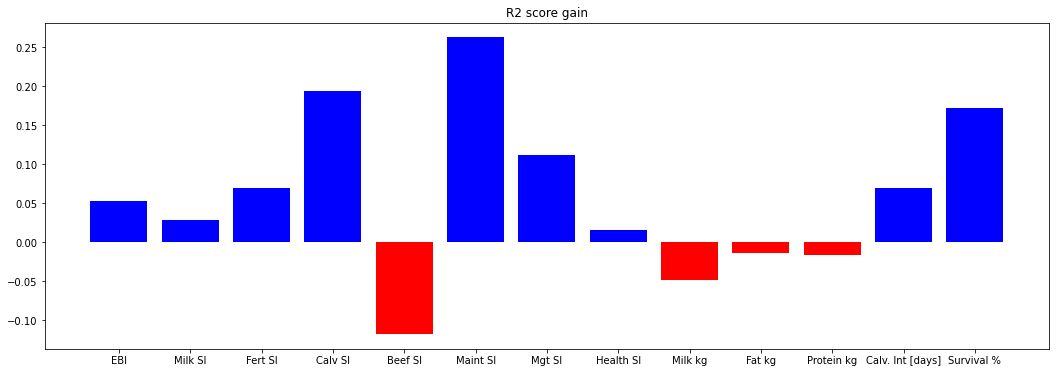

In [67]:
#Plotting the randomized search results in comparison to the benchmark results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(mlp_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [68]:
### Automatized grid search for each target feature
mlp_grid_record = []
mlp_grid_params = []
mlp_grid_estimators = []

scaled_X = scaler.fit_transform(X)

for i in range(len(mlp_record)):
    param_grid = {"hidden_layer_sizes": list(itertools.permutations([25,50,100],len(mlp_params[i]["hidden_layer_sizes"]))),
               "activation": [mlp_params[i]['activation']], 
               "solver": [mlp_params[i]['solver']],
               'learning_rate' : [mlp_params[i]['learning_rate']],
               "alpha": [mlp_params[i]['alpha']*0.9, mlp_params[i]['alpha'], mlp_params[i]['alpha']*1.1]}
    
    
    i = np.array(targets[i]).reshape(-1,1)
    scaled_y = scaler.fit_transform(i)
    scaled_y = np.array(scaled_y).reshape(len(scaled_y),)
    
    
    mlp = MLPRegressor(random_state=42)
    grid_search = GridSearchCV(estimator = mlp, param_grid = param_grid, cv = 5, n_jobs = -1, verbose = 2)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, scaled_y, test_size=test, random_state=42)
    grid_search.fit(X_train, y_train)
    mlp_grid_record += [grid_search.score(X_test, y_test)]
    mlp_grid_params += [grid_search.best_params_]
    mlp_grid_estimators += [grid_search.best_estimator_]

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits


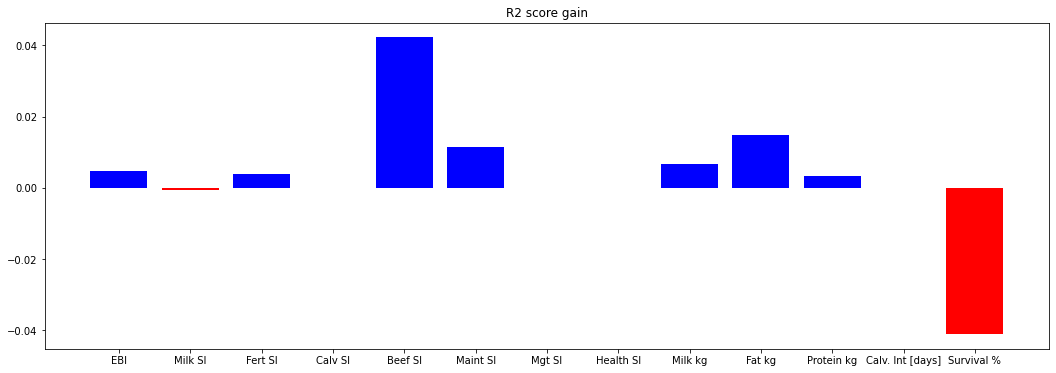

In [69]:
#Plotting the grid search results in comparison to the randomized search results
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(mlp_grid_record) - np.array(mlp_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

In [70]:
#Keeping only the grid search parameters that performed better than the randomized search ones
final_mlp_record = []
final_mlp_params = []
final_mlp_estimators = []
for i in range(len(mlp_record)):
    if mlp_grid_record[i] > mlp_record[i]:
        final_mlp_record += [mlp_grid_record[i]]
        final_mlp_params += [mlp_grid_params[i]]
        final_mlp_estimators += [mlp_grid_estimators[i]]
    else:
        final_mlp_record += [mlp_record[i]]
        final_mlp_params += [mlp_params[i]]
        final_mlp_estimators += [mlp_estimators[i]]

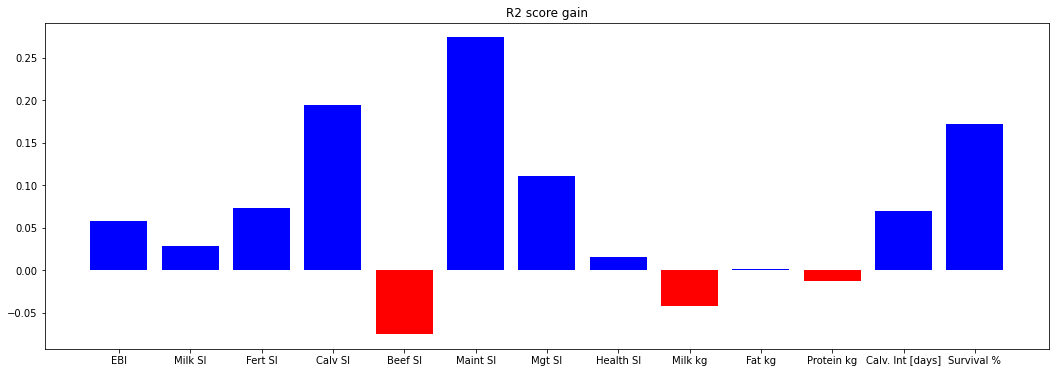

In [71]:
#Plotting the final results in comparison to the benchmark
x = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %']
y = np.array(final_mlp_record) - np.array(bench_record)

cc=['colors']*len(y)
for n,val in enumerate(y):
    if val<0:
        cc[n]='red'
    elif val>=0:
        cc[n]='blue'


figure(figsize=(18, 6))
plt.bar(x, y, color = cc)
plt.title('R2 score gain')
plt.show()

## Part 4: Results

In [154]:
#Compiling all the results in one array for easier access
results = np.array([final_record, final_reg_record, final_el_record, final_mlp_record, bench_record])

In [73]:
np.mean([results.T[0][0:4]-results.T[0][4],
         results.T[1][0:4]-results.T[1][4],
         results.T[2][0:4]-results.T[2][4],
         results.T[3][0:4]-results.T[3][4],
         results.T[5][0:4]-results.T[5][4],
         results.T[6][0:4]-results.T[6][4], 
         results.T[11][0:4]-results.T[11][4], 
         results.T[12][0:4]-results.T[12][4]])

0.1272697647577436

In [74]:
np.mean(results.T[8][0:4]-results.T[8][4])

-0.04105610686337283

In [75]:
np.mean([results.T[7][0:4]-results.T[7][4],
         results.T[9][0:4]-results.T[9][4],
         results.T[10][0:4]-results.T[10][4]])

0.0090337436041406

Text(0.5, 1.0, 'Results Summary')

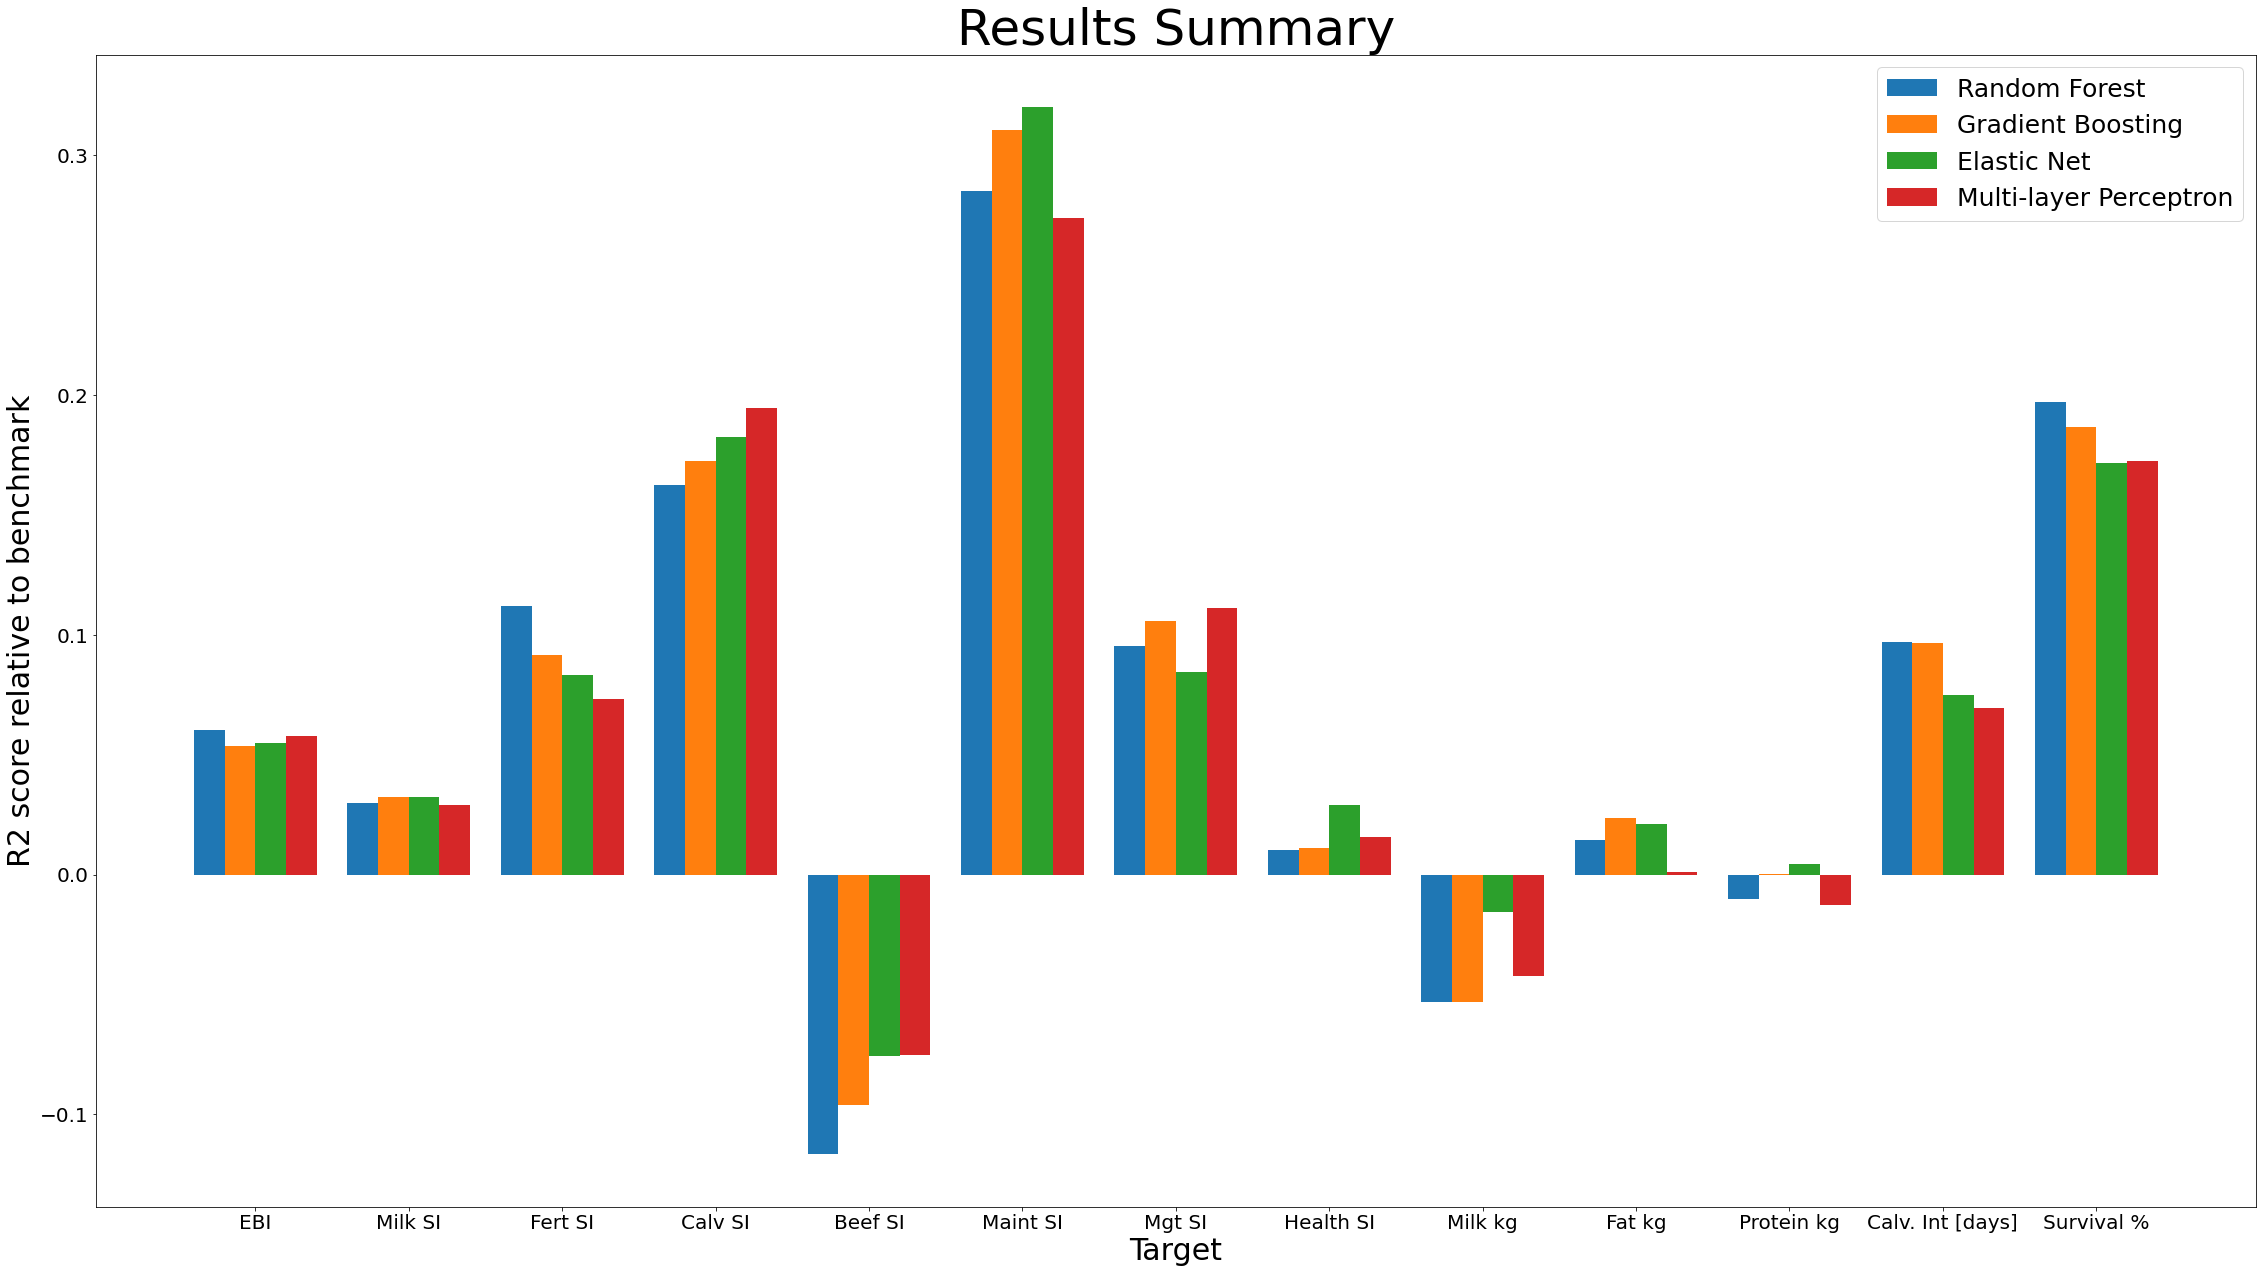

In [76]:
R = np.arange(13)
labels = []
for i in R:
    labels += [targets[i].name]
fig = plt.figure()
ax = fig.add_axes([0,0,5,4])
ax.bar(R - 0.3, results[0]-results[4], width=0.2, label = 'Random Forest')
ax.bar(R - 0.1, results[1]-results[4], width=0.2, label = 'Gradient Boosting')
ax.bar(R + 0.1, results[2]-results[4], width=0.2, label = 'Elastic Net')
ax.bar(R + 0.3, results[3]-results[4], width=0.2, label = 'Multi-layer Perceptron')

'''ax.bar(R - 0.3, results[0], width=0.15, label = 'Random Forest')
ax.bar(R - 0.15, results[1], width=0.15, label = 'Gradient Boosting')
ax.bar(R + 0.0, results[2], width=0.15, label = 'Elastic Net')
ax.bar(R + 0.15, results[3], width=0.15, label = 'Multilayer Perceptor')
ax.bar(R + 0.3, results[4], width=0.15, label = 'ICBF')'''

ax.set_xticks(R, labels, fontsize = 20)
plt.yticks(fontsize = 20)
ax.legend(fontsize = 25)
plt.ylabel('R2 score relative to benchmark', size = 30)
plt.xlabel('Target', size = 30)
ax.set_title('Results Summary', fontsize = 50)

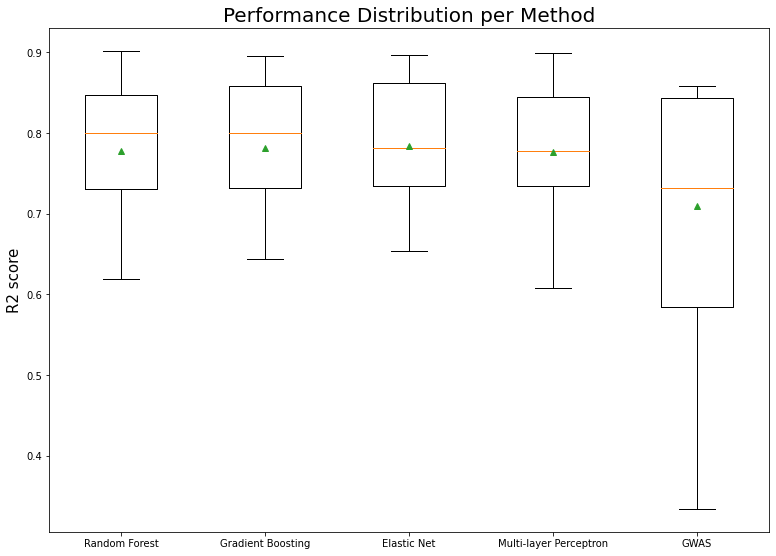

In [77]:
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0,0,1,1])
# Creating plot
ax.boxplot(results.T, labels = ['Random Forest', 'Gradient Boosting', 'Elastic Net', 'Multi-layer Perceptron', 'GWAS'], showmeans=True)
plt.ylabel('R2 score', size = 15)
ax.set_title('Performance Distribution per Method', fontsize = 20)
# show plot
plt.show()

In [78]:
#Results comparison by method
comp = pd.DataFrame([[np.var(results[0]), np.var(results[1]), np.var(results[2]), np.var(results[3]), np.var(results[4])],[np.mean(results[0]), np.mean(results[1]), np.mean(results[2]), np.mean(results[3]), np.mean(results[4])]], columns = ['Random Forest', 'Gradient Boosting', 'Elastic Net', 'Multi-layer Perceptron', 'GWAS'])
comp.set_index([['R2 Variance', 'Average R2']], inplace=True)

In [79]:
comp

,Random Forest,Gradient Boosting,Elastic Net,Multi-layer Perceptron,GWAS
R2 Variance,0.008022,0.006824,0.006751,0.006765,0.022960
Average R2,0.777576,0.781550,0.784021,0.776359,0.709621


In [80]:
print('Random Forest Variance = ',"{:.5f}".format(np.var(results[0])))
print('Gradient Boosting Variance = ',"{:.5f}".format(np.var(results[1])))
print('Elastic Net Variance = ',"{:.5f}".format(np.var(results[2])))
print('Multilayer Perceptor Variance = ',"{:.5f}".format(np.var(results[3])))
print('GWAS Variance = ',"{:.5f}".format(np.var(results[4])))

Random Forest Variance =  0.00802
Gradient Boosting Variance =  0.00682
Elastic Net Variance =  0.00675
Multilayer Perceptor Variance =  0.00676
GWAS Variance =  0.02296


Text(0.5, 1.0, 'ICBF prediction benchmark')

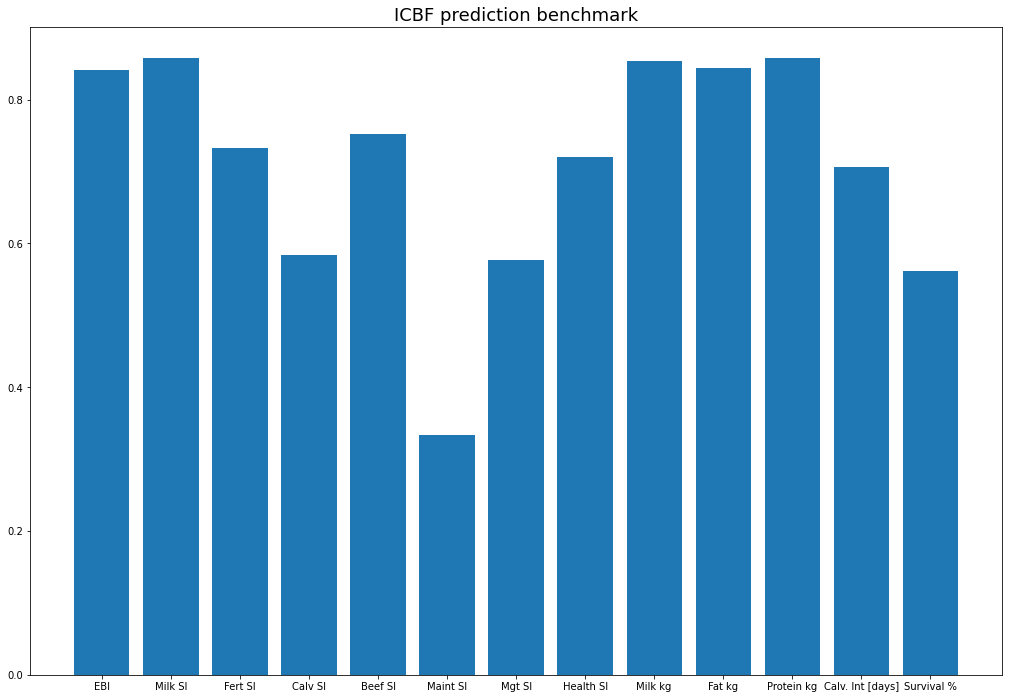

In [81]:
fig = plt.figure()
ax = fig.add_axes([0,0,2.25,2.25])
ax.bar(pd.DataFrame(targets).T.columns, bench_record)
ax.set_title('ICBF prediction benchmark', fontsize = 18)

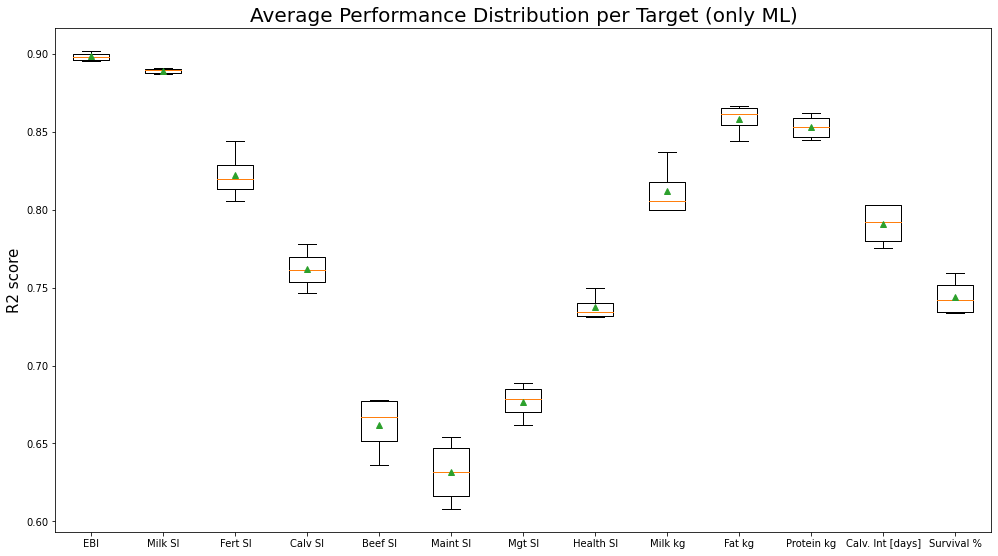

In [82]:
fig = plt.figure(figsize =(13, 7))
ax = fig.add_axes([0,0,1,1])
# Creating plot
ax.boxplot(results[0:4], showmeans=True, labels = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %'])
plt.ylabel('R2 score', size = 15)
ax.set_title('Average Performance Distribution per Target (only ML)', fontsize = 20)
# show plot
plt.show()

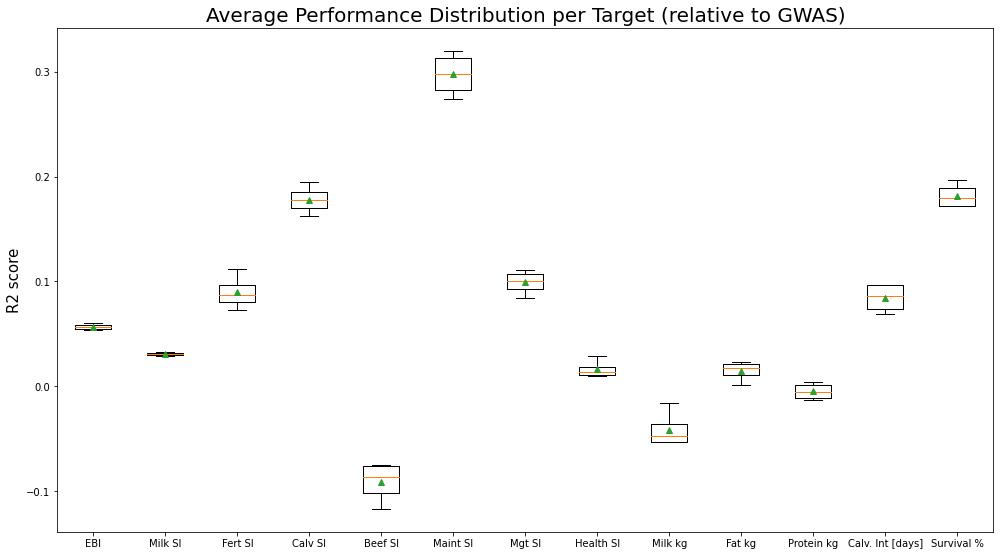

In [85]:
fig = plt.figure(figsize =(13, 7))
ax = fig.add_axes([0,0,1,1])
# Creating plot
ax.boxplot(np.array([results[0]-results[4], results[1]-results[4], results[2]-results[4], results[3]-results[4]]), showmeans=True, labels = ['EBI', 'Milk SI', 'Fert SI', 'Calv SI', 'Beef SI', 'Maint SI', 'Mgt SI', 'Health SI', 'Milk kg', 'Fat kg', 'Protein kg', 'Calv. Int [days]', 'Survival %'])
plt.ylabel('R2 score', size = 15)
ax.set_title('Average Performance Distribution per Target (relative to GWAS)', fontsize = 20)
# show plot
plt.show()

In [95]:
#Correlation between ML and GWAS
me = []
for i in range(13):
    me += [np.mean(results[0:4].T[i])]
np.corrcoef(me, results[4])

array([[1.        , 0.79207547],
       [0.79207547, 1.        ]])

In [134]:
#Correlation between GWAS and Sub Index ponderation
si_ponderation = [0.33, 0.33, 0.01, 0.08, 0.08, 0.04, 0.03]
np.corrcoef(list(bench_record[1:8]), si_ponderation)

array([[1.        , 0.53089034],
       [0.53089034, 1.        ]])

In [145]:
#Elastic Net R2 gain over GWAS
np.mean(results[2][[0, 1, 2, 3, 5, 6, 11, 12]])-np.mean(results[4][[0, 1, 2, 3, 5, 6, 11, 12]])

0.12547329487156322